## Task 1: Exploratory Data Analysis (EDA) and Data Preprocessing

The objective of this task is to understand the structure, quality, and characteristics
of the CFPB consumer complaint dataset and to prepare clean textual data suitable for
downstream Retrieval-Augmented Generation (RAG) tasks.

Specifically, this notebook explores:
- The distribution of complaints across financial products
- The availability and length of complaint narratives
- Data filtering based on project requirements
- Text cleaning and normalization


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.insert(0, os.path.abspath(".."))
sns.set_style("whitegrid")

df = pd.read_csv("../data/raw/complaints.csv", low_memory=False)
df.head()


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,Experian Information Solutions Inc.,FL,32092,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195687
1,2025-06-20,Debt collection,Telecommunications debt,Attempts to collect debt not owed,Debt is not yours,NaN,Company can't verify or dispute the facts in t...,"Eastern Account Systems of Connecticut, Inc.",FL,342XX,NaN,NaN,Web,2025-06-20,Closed with explanation,Yes,NaN,14195688
2,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195689
3,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,AZ,85225,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195690
4,2025-06-20,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account status incorrect,NaN,NaN,Experian Information Solutions Inc.,IL,60628,NaN,NaN,Web,2025-06-20,In progress,Yes,NaN,14195692


In [32]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9609797 entries, 0 to 9609796
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 1.3+

### Observations
- The dataset contains hundreds of thousands of complaint records.
- Several columns contain missing values, notably the consumer complaint narrative.
- The `product` column contains multiple financial product categories.


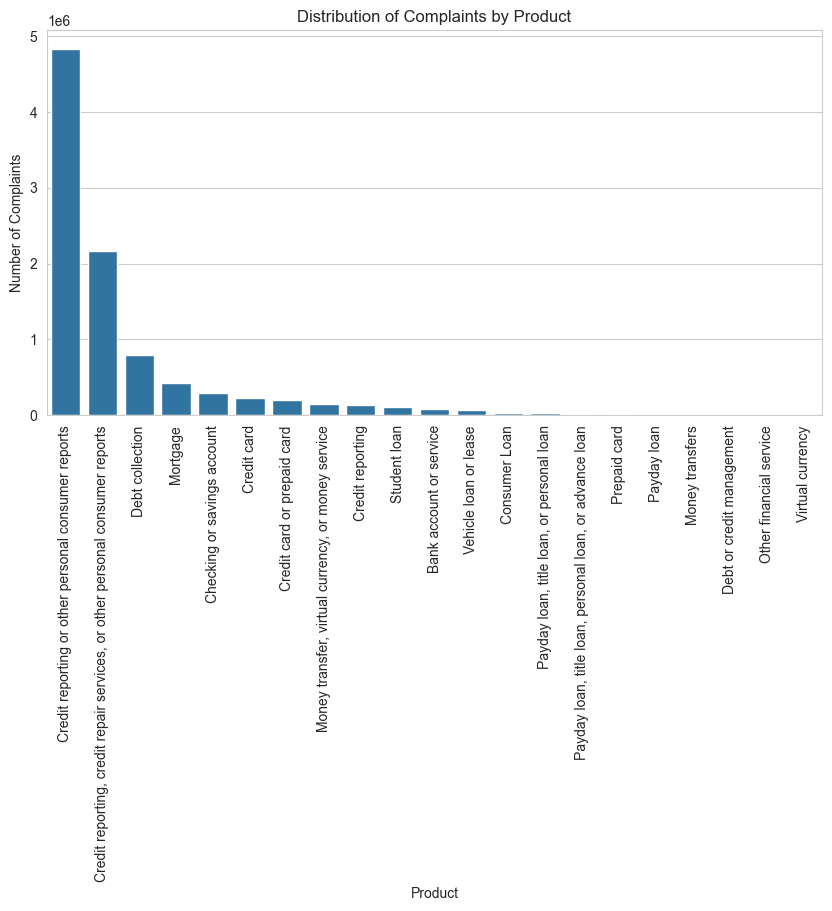

In [33]:
product_counts = df["Product"].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.xticks(rotation=90)
plt.title("Distribution of Complaints by Product")
plt.xlabel("Product")
plt.ylabel("Number of Complaints")
plt.show()


In [34]:
df.columns


Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

### Insight
Complaint volume varies significantly across products, with certain financial services
generating a much higher number of complaints than others.


In [35]:
df["Consumer complaint narrative"].isna().value_counts()


Consumer complaint narrative
True     6629041
False    2980756
Name: count, dtype: int64

### Insight
A significant portion of complaints do not include free-text narratives.
Only complaints with narratives will be useful for semantic search and RAG.


In [36]:
df["narrative_length"] = (
    df["Consumer complaint narrative"]
    .fillna("")
    .apply(lambda x: len(x.split()))
)


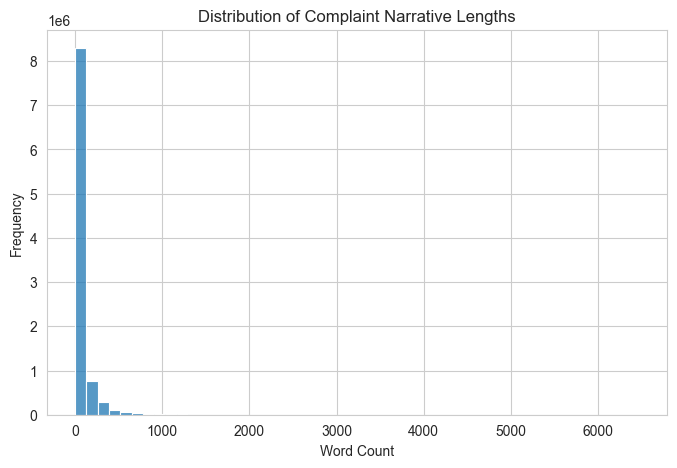

In [37]:
plt.figure(figsize=(8, 5))
sns.histplot(df["narrative_length"], bins=50)
plt.title("Distribution of Complaint Narrative Lengths")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()


###Insight

Complaint narratives vary widely in length.

Some narratives are extremely short, while others are very long.

This motivates the need for text chunking in later stages.

##Data Filtering

We restrict the dataset to:

Credit card

Personal loan

Savings account

Money transfer

Additionally, we remove complaints without narratives.

In [38]:
target_products = [
    "Credit card",
    "Personal loan",
    "Savings account",
    "Money transfer"
]

df_filtered = df[
    df["Product"].isin(target_products) &
    df["Consumer complaint narrative"].notna()
].copy()

df_filtered.shape


(80667, 19)

###Text Cleaning

To improve embedding quality, we apply the following preprocessing steps:

Lowercasing text

Removing special characters

Removing extra whitespace

In [39]:
import re

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [40]:
df_filtered["clean_narrative"] = (
    df_filtered["Consumer complaint narrative"]
    .apply(clean_text)
)

df_filtered[["Consumer complaint narrative", "clean_narrative"]].head()


,Consumer complaint narrative,clean_narrative
12237,A XXXX XXXX card was opened under my name by a...,a xxxx xxxx card was opened under my name by a...
13280,"Dear CFPB, I have a secured credit card with c...",dear cfpb i have a secured credit card with ci...
13506,I have a Citi rewards cards. The credit balanc...,i have a citi rewards cards the credit balance...
13955,b'I am writing to dispute the following charge...,b i am writing to dispute the following charge...
14249,"Although the account had been deemed closed, I...",although the account had been deemed closed i ...


In [41]:
df_filtered.to_csv(
    "../data/processed/filtered_complaints.csv",
    index=False
)


The cleaned and filtered dataset has been saved and will be used for:
- Text chunking
- Embedding generation
- Vector database indexing in subsequent tasks


## Task 1 Summary

In this task, we explored the CFPB consumer complaint dataset to understand its structure,
content, and suitability for building a RAG-based complaint analysis system. The analysis
revealed significant variation in complaint volume across products and wide differences
in narrative length, reinforcing the need for text chunking.

We filtered the dataset to the project’s target financial products and removed complaints
without narratives. Basic text normalization was applied to improve embedding quality.
The resulting cleaned dataset provides a strong foundation for semantic search and
retrieval-augmented generation in later stages.
